In [1]:
import os
import networkx as nx
import pandas as pd
import graspologic
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


data_dir = os.path.expanduser("~/Documents/Neural Data Design/cora")

## Load the CORA Dataset

In [2]:
edgelist = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep='\t', header=None, names=["target", "source"])
edgelist["label"] = "cites"

In [3]:
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")
nx.set_node_attributes(Gnx, "paper", "label")

In [4]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None, names=column_names)
Y = node_data.to_numpy()[:, 0:1433]
labels = node_data["subject"].to_numpy()

In [5]:
A = graspologic.utils.import_graph(Gnx)

## CASE

In [6]:
def plot_latents(latent_positions, *, title, labels, ax=None):
    if ax is None:
        ax = plt.gca()
    plot = sns.scatterplot(latent_positions[:, 0], latent_positions[:, 1], hue=labels, 
                           linewidth=0, s=10, ax=ax, palette="Set1")
    plot.set_title(title, wrap=True);
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.legend(bbox_to_anchor=(1.5, 1), loc="upper right", title="Community")
    
    return plot

/Users/ze/opt/miniconda3/envs/Stellar/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


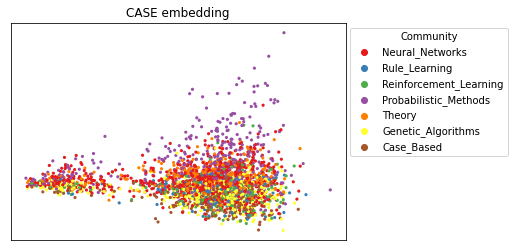

In [7]:
from graspologic.embed import CovariateAssistedEmbed as CASE

case = CASE(alpha=0.5, assortative=False, n_components=16)
latents = case.fit_transform((A, Y))
plot_latents(latents, title=r"CASE embedding", labels=labels);

In [8]:
print("The ratio of the leading eigenvector is:", case.alpha_)

The ratio of the leading eigenvector is: 0.5


## Train a classifier on CASE latent positions

In [9]:
from sklearn import preprocessing, model_selection

node_subjects = pd.Series(labels)
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.1, test_size=None, stratify=node_subjects
)

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
test_targets = target_encoding.transform(test_subjects)


train_data = latents[train_subjects.index.values, :]
test_data = latents[test_subjects.index.values, :]

## Create Keras model

In [10]:
from tensorflow.keras import layers, optimizers, losses, metrics, Model, Sequential, utils

model = Sequential(
    layers.Dense(units=train_targets.shape[1], activation="softmax")
)

In [11]:
model.compile(
    optimizer=optimizers.Adam(lr=0.03),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

## Train the model

In [12]:
model.fit(train_data, train_targets, epochs=100)

Epoch 1/100
9/9 [==============================] - 0s 800us/step - loss: 1.9321 - acc: 0.1897
Epoch 2/100
9/9 [==============================] - 0s 589us/step - loss: 1.8637 - acc: 0.2615
Epoch 3/100
9/9 [==============================] - 0s 609us/step - loss: 1.8017 - acc: 0.2942
Epoch 4/100
9/9 [==============================] - 0s 602us/step - loss: 1.7737 - acc: 0.3069
Epoch 5/100
9/9 [==============================] - 0s 598us/step - loss: 1.7486 - acc: 0.2916
Epoch 6/100
9/9 [==============================] - 0s 652us/step - loss: 1.7102 - acc: 0.3120
Epoch 7/100
9/9 [==============================] - 0s 644us/step - loss: 1.7006 - acc: 0.2938
Epoch 8/100
9/9 [==============================] - 0s 637us/step - loss: 1.7388 - acc: 0.2723
Epoch 9/100
9/9 [==============================] - 0s 614us/step - loss: 1.6579 - acc: 0.3238
Epoch 10/100
9/9 [==============================] - 0s 653us/step - loss: 1.6592 - acc: 0.3283
Epoch 11/100
9/9 [==============================] - 0s 643u

## Evaluate the model

In [13]:
test_loss, test_acc = model.evaluate(test_data,  test_targets, verbose=2)

print('\nTest accuracy:', test_acc)

77/77 - 0s - loss: 1.0352 - acc: 0.6920

Test accuracy: 0.6919606328010559


## Make prediction for all the nodes

In [14]:
all_predictions = model.predict(latents)

In [15]:
node_predictions = target_encoding.inverse_transform(all_predictions)

/Users/ze/opt/miniconda3/envs/Stellar/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


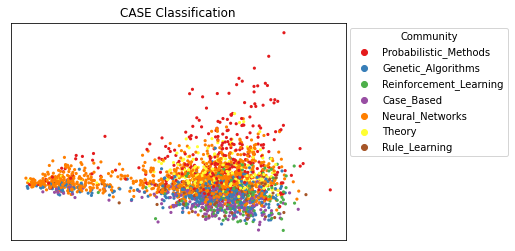

In [16]:
plot_latents(latents, title=r"CASE Classification", labels=node_predictions);

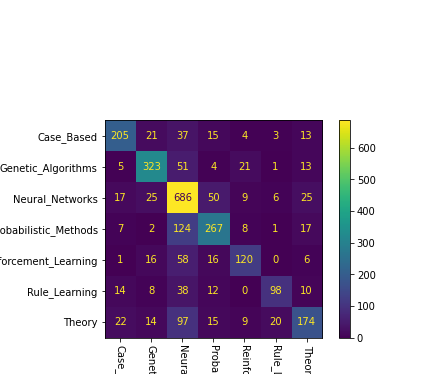

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels, node_predictions, labels=['Case_Based', 'Genetic_Algorithms', 'Neural_Networks',
       'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning',
       'Theory'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Case_Based', 'Genetic_Algorithms', 'Neural_Networks',
       'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning',
       'Theory'])
disp.plot(xticks_rotation=270)

## K-fold Validation

In [18]:
num_folds = 10
acc_per_fold = []
loss_per_fold = []

skf = model_selection.StratifiedKFold(n_splits=num_folds)

fold_no = 1
for train_index, test_index in skf.split(latents, node_subjects):
    train_subjects, test_subjects = node_subjects[train_index], node_subjects[test_index]
    target_encoding = preprocessing.LabelBinarizer()

    train_targets = target_encoding.fit_transform(train_subjects)
    test_targets = target_encoding.transform(test_subjects)

    train_data = latents[train_subjects.index.values, :]
    test_data = latents[test_subjects.index.values, :]

    model = Sequential(
        layers.Dense(units=train_targets.shape[1], activation="softmax")
    )
    model.compile(
        optimizer=optimizers.Adam(lr=0.03),
        loss=losses.categorical_crossentropy,
        metrics=["acc"],
    )
    model.fit(train_data, train_targets, epochs=80, verbose=0)
    test_loss, test_acc = model.evaluate(test_data,  test_targets, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {test_loss}; {model.metrics_names[1]} of {test_acc}')
    acc_per_fold.append(test_acc)
    loss_per_fold.append(test_loss)

    # Increase fold number
    fold_no = fold_no + 1

Score for fold 1: loss of 0.9022893309593201; acc of 0.7380073666572571
Score for fold 2: loss of 0.8551669120788574; acc of 0.7011070251464844
Score for fold 3: loss of 0.7985814213752747; acc of 0.7601476311683655
Score for fold 4: loss of 0.7886976599693298; acc of 0.7047970294952393
Score for fold 5: loss of 0.8405081033706665; acc of 0.7416974306106567
Score for fold 6: loss of 0.8916248679161072; acc of 0.678966760635376
Score for fold 7: loss of 0.8210463523864746; acc of 0.7047970294952393
Score for fold 8: loss of 0.8037422895431519; acc of 0.7380073666572571
Score for fold 9: loss of 0.8377495408058167; acc of 0.7259259223937988
Score for fold 10: loss of 1.0044050216674805; acc of 0.6629629731178284


## Search in alpha, n_components = 16

In [19]:
M = 30
N = 1
a_range = np.geomspace(10e-5, 1, num=M)
test_loss = np.zeros((M, N))
test_acc = np.zeros((M, N))

for a, i in zip(a_range, range(0, M)):
    case = CASE(alpha=a, assortative=True, n_components=16)
    latents = case.fit_transform((A, Y))
    train_data = latents[train_subjects.index.values, :]
    test_data = latents[test_subjects.index.values, :]
    model = Sequential(
        layers.Dense(units=train_targets.shape[1], activation="softmax")
    )
    model.compile(
        optimizer=optimizers.Adam(lr=0.03),
        loss=losses.categorical_crossentropy,
        metrics=["acc"],
    )
    model.fit(train_data, train_targets, epochs=50, verbose=0)
    test_loss[i, 0], test_acc[i, 0] = model.evaluate(test_data,  test_targets, verbose=0)

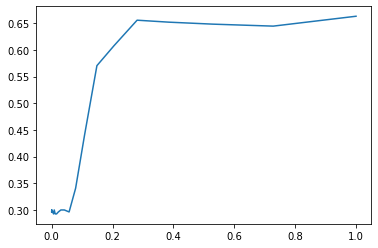

In [20]:
plt.plot(a_range, test_acc)

## Search in n_components, alpha = 0.5

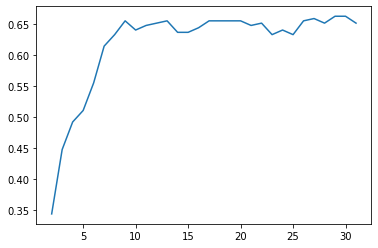

In [30]:
M = 1
N = 30
a_range = np.geomspace(10e-5, 1, num=M)
components_range = range(2, N+2)
test_loss = np.zeros((N, 1))
test_acc = np.zeros((N, 1))

for n, j in zip(components_range, range(0, N)):
    case = CASE(alpha=0.5, assortative=True, n_components=n)
    latents = case.fit_transform((A, Y))
    train_data = latents[train_subjects.index.values, :]
    test_data = latents[test_subjects.index.values, :]
    model = Sequential(
        layers.Dense(units=train_targets.shape[1], activation="softmax")
    )
    model.compile(
        optimizer=optimizers.Adam(lr=0.03),
        loss=losses.categorical_crossentropy,
        metrics=["acc"],
    )
    model.fit(train_data, train_targets, epochs=50, verbose=0)
    test_loss[j, 0], test_acc[j, 0] = model.evaluate(test_data,  test_targets, verbose=0)

plt.plot(components_range, test_acc)

## Search in alpha and n_components

In [26]:
M = 20
N = 20
a_range = np.geomspace(10e-5, 1, num=M)
components_range = range(2, N+2)
test_loss = np.zeros((M, N))
test_acc = np.zeros((M, N))

for a, i in zip(a_range, range(0, M)):
    for n, j in zip(components_range, range(0, N)):
        case = CASE(alpha=a, assortative=True, n_components=n)
        latents = case.fit_transform((A, Y))
        train_data = latents[train_subjects.index.values, :]
        test_data = latents[test_subjects.index.values, :]
        model = Sequential(
            layers.Dense(units=train_targets.shape[1], activation="softmax")
        )
        model.compile(
            optimizer=optimizers.Adam(lr=0.03),
            loss=losses.categorical_crossentropy,
            metrics=["acc"],
        )
        model.fit(train_data, train_targets, epochs=50, verbose=0)
        test_loss[i, j], test_acc[i, j] = model.evaluate(test_data,  test_targets, verbose=0)

In [27]:
a_range = np.geomspace(10e-5, 1, num=M)
components_range = range(2, N+2)
components_range, a_range = np.meshgrid(components_range, a_range)

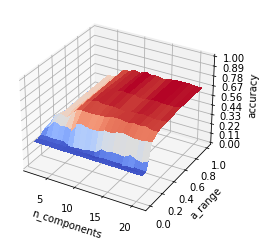

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig = plt.figure()
ax = plt.axes(projection='3d')

surf = ax.plot_surface(components_range, a_range, test_acc, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 1)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

ax.set_xlabel('n_components')
ax.set_ylabel('a_range')
ax.set_zlabel('accuracy');

## k-fold validation for GraphSAGE

In [37]:
import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE
from stellargraph import datasets

dataset = datasets.Cora()
G, node_subjects = dataset.load()

num_folds = 10
acc_per_fold = []
loss_per_fold = []

batch_size = 50
num_samples = [10, 5]  

skf = model_selection.StratifiedKFold(n_splits=num_folds)

fold_no = 1
for train_index, test_index in skf.split(np.zeros(2708), node_subjects):
    train_subjects, test_subjects = node_subjects.iloc[train_index], node_subjects.iloc[test_index]
    target_encoding = preprocessing.LabelBinarizer()

    train_targets = target_encoding.fit_transform(train_subjects)
    test_targets = target_encoding.transform(test_subjects)
    target_encoding = preprocessing.LabelBinarizer()

    train_targets = target_encoding.fit_transform(train_subjects)
    test_targets = target_encoding.transform(test_subjects)

    generator = GraphSAGENodeGenerator(G, batch_size, num_samples)

    train_gen = generator.flow(train_subjects.index, train_targets, shuffle=True)

    graphsage_model = GraphSAGE(
        layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
    )

    x_inp, x_out = graphsage_model.in_out_tensors()
    prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

    model = Model(inputs=x_inp, outputs=prediction)
    model.compile(
        optimizer=optimizers.Adam(lr=0.005),
        loss=losses.categorical_crossentropy,
        metrics=["acc"],
    )
    model.fit(train_gen, epochs=20, verbose=0, shuffle=False)
    test_gen = generator.flow(test_subjects.index, test_targets)
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {test_loss}; {model.metrics_names[1]} of {test_acc}')
    acc_per_fold.append(test_acc)
    loss_per_fold.append(test_loss)

    # Increase fold number
    fold_no = fold_no + 1

6/6 [==============================] - 0s 27ms/step - loss: 0.5854 - acc: 0.8376
Score for fold 1: loss of 0.5854122638702393; acc of 0.8376383781433105
6/6 [==============================] - 0s 25ms/step - loss: 0.4639 - acc: 0.8782
Score for fold 2: loss of 0.4638881981372833; acc of 0.8782287836074829
6/6 [==============================] - 0s 26ms/step - loss: 0.3849 - acc: 0.8967
Score for fold 3: loss of 0.3849186897277832; acc of 0.8966789841651917
6/6 [==============================] - 0s 24ms/step - loss: 0.5713 - acc: 0.8524
Score for fold 4: loss of 0.5712618827819824; acc of 0.8523985147476196
6/6 [==============================] - 0s 25ms/step - loss: 0.5458 - acc: 0.8598
Score for fold 5: loss of 0.5458487868309021; acc of 0.8597785830497742
6/6 [==============================] - 0s 29ms/step - loss: 0.5463 - acc: 0.8524
Score for fold 6: loss of 0.5463421940803528; acc of 0.8523985147476196
6/6 [==============================] - 0s 24ms/step - loss: 0.4302 - acc: 0.8930
S